<div class="jumbotron text-left"><b>
    
This tutorial describes how to use the SMT toolbox to do some Bayesian Optimization (MOO method) to solve multi-objective unconstrained optimization problem
<div>
    
Robin Grapin - 2021
    
https://github.com/RobinGRAPIN?tab=repositories

# Problem definition

Let us go with a 2-objectives function from a 2-D variable. Feel free to choose the objectives within the SMT Problems and to change the bounds.

In [1]:
from platform import python_version
print(python_version()) #python version has to be > 3.6 to use pymoo
import sys
#!pip install pymoo smt smoot

3.8.8


In [1]:
#imports
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import time

from smt.problems import Rosenbrock, Branin
from smt.sampling_methods import LHS
from smt.surrogate_models import LS, QP, KPLS, KRG, KPLSK, GEKPLS, MGP

from pymoo.algorithms.nsga2 import NSGA2
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_problem, get_reference_directions, get_performance_indicator, get_visualization
from pymoo.util.plotting import plot

from smoot import pymoo2fun, pymoo2constr
from smoot.smoot import MOO
from smoot import ZDT

In [10]:
#problem definition
ndim = 2 #design space dimension
ny = 2   #objective space dimension
fun1 = Rosenbrock(ndim=ndim)
fun2 = Branin(ndim=ndim)

#function to minimize, must be f : ndarray[n_points, n_dim] -> ndarray[n_points, ny]
def objective(x):
    return np.transpose(np.array([fun1(x),fun2(x)]))[0]
    
xlimits = np.array([[-2.0,2.0], [-2.0,2.0]])

<ipython-input-11-468065f758e0>:14: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


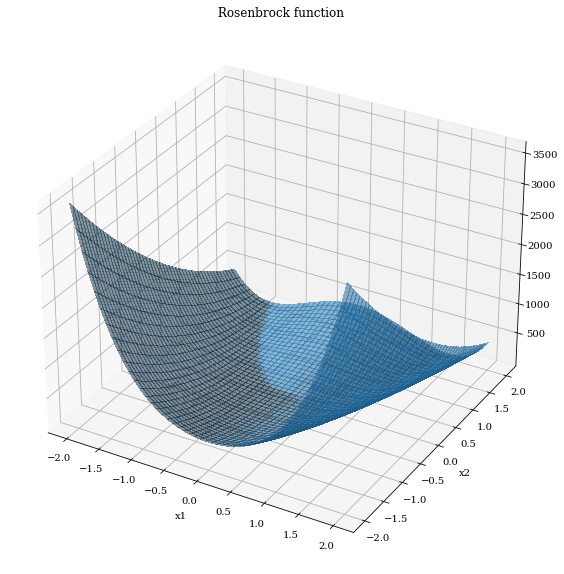

<ipython-input-11-468065f758e0>:29: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


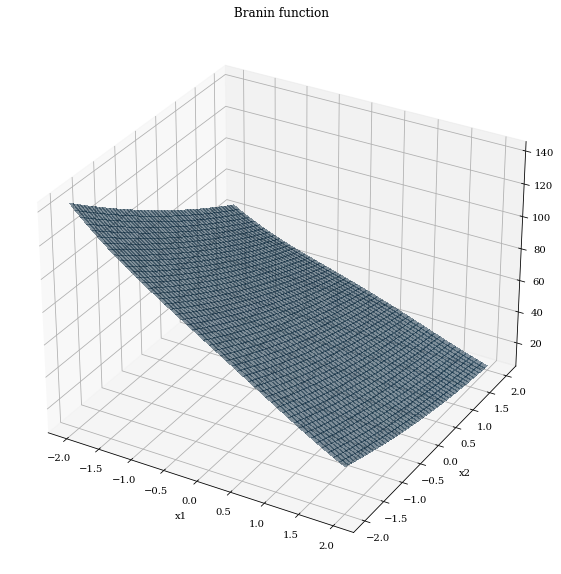

In [11]:
#plot of objective functions
%matplotlib inline
#To plot the Rosenbrock function
num_plot = 50 #to plot rosenbrock
x = np.linspace(xlimits[0][0],xlimits[0][1],num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(fun1(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, res,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title(' Rosenbrock function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

res2 = []
for x0 in x:
    for x1 in x:
        res2.append(fun2(np.array([[x0,x1]])))
res2 = np.array(res2)
res2 = res2.reshape((50,50)).T
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, res2,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title(' Branin function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Real Pareto front

The goal in multi-objective optimization is to find a set of points dominated by no others. To see the Pareto front of our function, let's run the genetic algorithm NSGA2 on it, without using surrogates. This will serve for comparition later.

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |       7 |            - |            -
    2 |     200 |      10 |  0.048512864 |        ideal
    3 |     300 |      13 |  0.063567065 |        ideal
    4 |     400 |      16 |  0.013962172 |        ideal
    5 |     500 |      21 |  0.037321155 |            f
    6 |     600 |      27 |  0.032217709 |        ideal
    7 |     700 |      33 |  0.012048377 |            f
    8 |     800 |      38 |  0.003363461 |        ideal
    9 |     900 |      43 |  0.003377972 |        ideal
   10 |    1000 |      52 |  0.025269460 |        nadir
   11 |    1100 |      69 |  0.032579274 |        nadir
   12 |    1200 |      78 |  0.005820871 |        nadir
   13 |    1300 |      95 |  0.019093281 |        nadir
   14 |    1400 |     100 |  0.160239534 |        nadir
   15 |    1500 |     100 |  0.003087440 |        nadir
   16 |    1600 |     100 |  0.000780646 |            f
   17 |    1700 |     100 |  0.001107905 |      

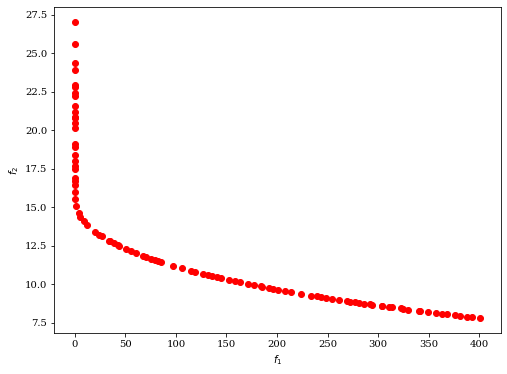

In [12]:
#creation of a Pymoo problem to be able to use NSGA2 on it
class MyProblem_reel(Problem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([-2.0, -2.0]),
                         xu=np.array([2.0, 2.0]),
                         elementwise_evaluation=True)

    def _evaluate(self, x, out, *args, **kwargs):
        xx = np.asarray(x).reshape(1, -1) #Our functions take array as entry
        f1 = fun1(xx)[0][0]
        f2 = fun2(xx)[0][0]
        out["F"] = [f1, f2]
        #out["G"] = [g1, g2] #no constraints at the moment

problem_exact = MyProblem_reel()

algorithm_bis = NSGA2(pop_size=100)

res_exact = minimize(problem_exact,
               algorithm_bis,
               ("n_gen", 100),
               verbose=True, #False if you do not want the text
               seed=1)

plot = Scatter()
plot.add(res_exact.F, color="red")
plot.show()

# Using a surrogate model

As the objective function might be expensive to call, using genetic algorithm on it can be very long. This is why MOO is used to :

 1) create a model with the Krige method  
 2) refine the by model chosing cleverly the points to evaluate  
 3) running NSGA2 on a good model to obtain the Pareto set and front  

In [13]:
#creation of a MOO object
mo = MOO(n_iter = 10, #added points to refine the model
         n_start = 20, #points for the initial sampling (sampling method : LHS)
         xlimits = xlimits, 
         verbose = True, #to know what is happening during the run
         n_gen=50, #number of generations for the genetic algorithm
         pop_size = 50)#number of new individuals at every generation of NSGA2

iteration 1
criterion max value : 618.4236901753184
xopt : [2.         1.56725457]
iteration 2
criterion max value : 23809.727192425275
xopt : [0.49179903 0.05663658]
iteration 3
criterion max value : 1253.3442506357321
xopt : [2. 2.]
iteration 4
criterion max value : 189.0141138037825
xopt : [1.61061639 1.00617006]
iteration 5
criterion max value : 196.5218717287259
xopt : [ 0.80848451 -0.39141673]
iteration 6
criterion max value : 1333.3903782475622
xopt : [1.9955328  1.99996294]
iteration 7
criterion max value : 52703.30048633392
xopt : [1.05119316 0.94068485]
iteration 8
criterion max value : 0.0
xopt : [0.72252357 1.73804136]
iteration 9
criterion max value : 275.00724525255873
xopt : [1.30312775 0.76160526]
iteration 10
criterion max value : 0.0
xopt : [ 1.31067982 -1.07468765]
Model is well refined, NSGA2 is running...
Optimization done, get the front with .result.F and the set with .result.X


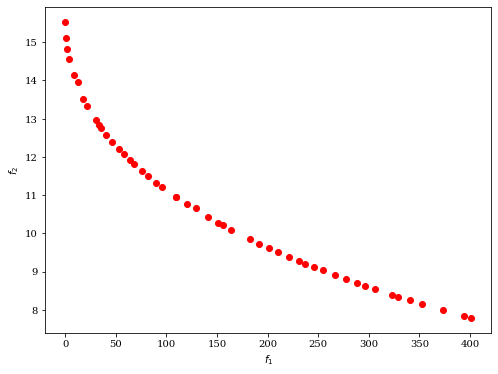

In [14]:
#optimization
mo.optimize(objective)

#vizualization of the Pareto front
res = mo.result
plot = Scatter()
plot.add(res.F, color="red")
plot.show()

<div>In this example, the objective function <code>objective</code> has been called <i>n_start + n_iter</i> times. </div>
We can see that the obtained front is close from the one obtained without using surrogates. You can now play with the function to optimize <code>objective</code>, the bounds <code>xlimits</code>, but also the parameters of MOO itself. For example, when defining the MOO object, you can declare <code>criterion =</code> for a different activation function in the model's refining loop.

## Method comparition

One of the crucial points of bayesian optimization is the way the points are iteratively selected to improve the surrogate model. Here, we will compare the efficiency of the differents model's improvement methods. The benchmark functions will be the ZDT functions from Zitzler et al. Their Pareto optima is given by an explicit formulae, what allows to mesure the pecision of our results. 

In [4]:
ndim =2
benchmark = [ZDT(type = 1,ndim = ndim),ZDT(type = 2,ndim = ndim),ZDT(type = 3,ndim = ndim)]
n_start = 10
xlimits = benchmark[0].xlimits
n_start = 5 #small to augment the importance of the criterion
n_iter = 20

#scalarized problem
points = 10 #values of alpha for the scalarized problem
alphas = np.linspace(0,1,points)

# setup of solvers using different methods
ego = MOO(n_iter=n_iter, n_start = n_start, xlimits=xlimits) #for scalarization. EGO is called by MOO when only 1 objective
moga = MOO(n_iter = n_iter,criterion = "GA", n_start = n_start, xlimits = xlimits, n_gen=30, pop_size = 30, random_state = 3)
mopi = MOO(n_iter = n_iter,criterion = "PI", n_start = n_start, xlimits = xlimits, n_gen=50, pop_size = 50, random_state = 3)
moei = MOO(n_iter = n_iter,criterion = "EHVI", n_start = n_start, xlimits = xlimits, n_gen=50, pop_size = 50, random_state = 3)
mowb = MOO(n_iter = n_iter,criterion = "WB2S", n_start = n_start, xlimits = xlimits, n_gen=50, pop_size = 50, random_state = 3)

In [5]:
# run the optimizations with each method on each function
yscal, ypi, yga, yei, ywb, ytrue = [],[],[],[],[],[]
for zdt in benchmark:
    print("Loop for function ZDT %s" % zdt.options["type"])    
    start_time = time.time()
    
    pts_scalar, i = np.zeros((points, ndim)),0
    for alpha in alphas :
        ego.optimize(lambda x: alpha*zdt(x)[0] + (1-alpha)*zdt(x)[1])
        pts_scalar[i]=ego.result.X
    yscal.append(zdt(pts_scalar))
    ego_time = time.time()
    print("ego method finished in",ego_time - start_time,"seconds for", points,"points" )
    
    mopi.optimize(zdt)
    ypi.append( np.array(mopi.result.F) )
    pi_time = time.time()
    print("PI method finished in",pi_time - ego_time,"seconds")
    
    moga.optimize(zdt)
    yga.append( np.array(moga.result.F) )
    ga_time = time.time()
    print("GA method finished in",ga_time - pi_time,"seconds")
    
    moei.optimize(zdt)
    yei.append( np.array(moei.result.F) )
    ei_time = time.time()
    print("EHVI method finished",ei_time - ga_time,"seconds")
    
    mowb.optimize(zdt)
    ywb.append( np.array(mowb.result.F) )
    wb_time = time.time()
    print("WB2S method finished",wb_time - ei_time,"seconds \n")
    
    _,y = zdt.pareto(300)
    ytrue.append(y)

Loop for function ZDT 1
ego method finished in 92.14636135101318 seconds for 10 points
PI method finished in 7.981257200241089 seconds
GA method finished in 16.16247296333313 seconds
EHVI method finished 30.74913501739502 seconds
WB2S method finished 496.38453936576843 seconds 

Loop for function ZDT 2
ego method finished in 98.02680802345276 seconds for 10 points
PI method finished in 8.060014247894287 seconds
GA method finished in 15.417214632034302 seconds
EHVI method finished 19.39473009109497 seconds
WB2S method finished 65.95521950721741 seconds 

Loop for function ZDT 3
ego method finished in 95.00006246566772 seconds for 10 points
PI method finished in 6.406996965408325 seconds
GA method finished in 15.359915256500244 seconds
EHVI method finished 20.142810821533203 seconds
WB2S method finished 177.87688446044922 seconds 



### Distance function

Usual indicators of similarity cannot conciliate the 3 criterias that make of an algorithm output a good approximation of the Pareto front : 
 - The proximity with the real values to take
 - The number of points
 - The repartition of the points across the variety of the possible values

The indicator that is used here takes in account these 3 factors by creating a kridge model with the obtained points. Then, the distance between the model's mean and the real front can be measured in random points, not only those obtained. This way, if the amount of points is too low or if they do not well cover the objective space, the model will not be very accurate.

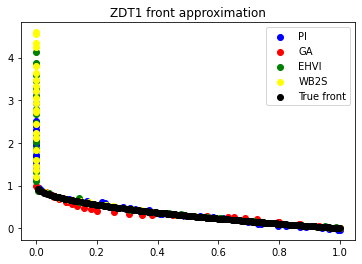

distance scalarized to true front 0.5701988493583442
distance PI to true front 0.02371634263710868
distance GA to true front 0.04241945547508471
distance EHVI to true front 0.008447993404607768
distance WB2S to true front 0.006265800570715829


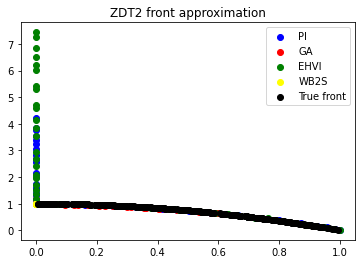

distance scalarized to true front 0.3619334894118538
distance PI to true front 0.04305440732935255
distance GA to true front 2.4124658244695185
distance EHVI to true front 0.04148061314805515
distance WB2S to true front 0.11795455120391526


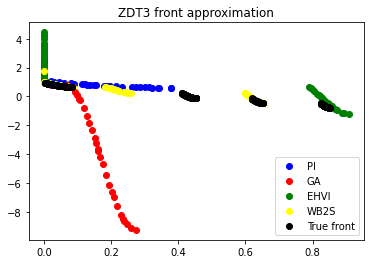

distance scalarized to true front 0.6647952096672093
distance PI to true front 0.313142495585199
distance GA to true front 0.0004491500254975668
distance EHVI to true front 0.13721535368650503
distance WB2S to true front 0.002954974738864772


In [6]:
def ecart_front(y1,y2,fun,pts = 200):
    """
        For a 2-objective front, compare the obtained results y1 and y2
        to the exact pareto front of the fun function to optimize.
        The method creates a kriging model with the obtained points
    """
    n=len(y1)
    #rotation along the neutral axis z1 and the amelioration axis z2
    z1_train = [ (y1[i]-y2[i])/2**.5 for i in range(n)]
    z2_train = [ (y1[i]+y2[i])/2**.5 for i in range(n)]

    # krigeage
    t = KRG(print_global = False)
    t.set_training_values(np.asarray(z1_train), np.asarray(z2_train))
    t.train()

    # Comparison points
    _,y = fun.pareto(pts)
    z1 = [ (y[0][i]-y[1][i])/2**.5 for i in range(pts)]
    z2 = [ (y[0][i]+y[1][i])/2**.5 for i in range(pts)]
    S = t.predict_values(np.asarray(z1))

    #dist
    return sum([abs(z2[i]-S[i,0]) for i in range(pts)])[0]/pts

#Results plot
%matplotlib inline
plt.figure(1)
#plt.scatter(yscal[0][:,0], yscal[0][:,1], c = "orange", label = "Scal")
plt.scatter(ypi[0][:,0], ypi[0][:,1], c = "blue", label = "PI")
plt.scatter(yga[0][:,0], yga[0][:,1], c = "red", label = "GA")
plt.scatter(yei[0][:,0], yei[0][:,1], c = "green", label = "EHVI")
plt.scatter(ywb[0][:,0], ywb[0][:,1], c = "yellow", label = "WB2S")
plt.scatter(ytrue[0][0], ytrue[0][1], c = "black", label = "True front")
plt.legend()
plt.title("ZDT1 front approximation")
plt.show()
print("distance scalarized to true front",ecart_front(yscal[0][:,0], yscal[0][:,1],benchmark[0]))
print("distance PI to true front",ecart_front(ypi[0][:,0], ypi[0][:,1],benchmark[0]))
print("distance GA to true front",ecart_front(yga[0][:,0], yga[0][:,1],benchmark[0]))
print("distance EHVI to true front",ecart_front(yei[0][:,0], yei[0][:,1],benchmark[0]))
print("distance WB2S to true front",ecart_front(ywb[0][:,0], ywb[0][:,1],benchmark[0]))

plt.figure()
#plt.scatter(yscal[1][:,0], yscal[1][:,1], c = "orange", label = "Scal")
plt.scatter(ypi[1][:,0], ypi[1][:,1], c = "blue", label = "PI")
plt.scatter(yga[1][:,0], yga[1][:,1], c = "red", label = "GA")
plt.scatter(yei[1][:,0], yei[1][:,1], c = "green", label = "EHVI")
plt.scatter(ywb[1][:,0], ywb[1][:,1], c = "yellow", label = "WB2S")
plt.scatter(ytrue[1][0], ytrue[1][1], c = "black", label = "True front")
plt.legend()
plt.title("ZDT2 front approximation")
plt.show()
print("distance scalarized to true front",ecart_front(yscal[1][:,0], yscal[1][:,1],benchmark[1]))
print("distance PI to true front",ecart_front(ypi[1][:,0], ypi[1][:,1],benchmark[1]))
print("distance GA to true front",ecart_front(yga[1][:,0], yga[1][:,1],benchmark[1]))
print("distance EHVI to true front",ecart_front(yei[1][:,0], yei[1][:,1],benchmark[1]))
print("distance WB2S to true front",ecart_front(ywb[1][:,0], ywb[1][:,1],benchmark[1]))

plt.figure()
#plt.scatter(yscal[2][:,0], yscal[2][:,1], c = "orange", label = "Scal")
plt.scatter(ypi[2][:,0], ypi[2][:,1], c = "blue", label = "PI")
plt.scatter(yga[2][:,0], yga[2][:,1], c = "red", label = "GA")
plt.scatter(yei[2][:,0], yei[2][:,1], c = "green", label = "EHVI")
plt.scatter(ywb[2][:,0], ywb[2][:,1], c = "yellow", label = "WB2S")
plt.scatter(ytrue[2][0], ytrue[2][1], c = "black", label = "True front")
plt.legend()
plt.title("ZDT3 front approximation")
plt.show()
# for the discontinue front we will use an other indicator : IGD+
from pymoo.factory import get_performance_indicator
from pymoo.factory import get_problem
pf = get_problem("zdt1").pareto_front()
igd_plus = get_performance_indicator("igd+", pf)
print("distance scalarized to true front",igd_plus.calc(np.transpose(np.asarray(yscal[2]))[0]))
print("distance PI to true front",igd_plus.calc(ypi[2]))
print("distance GA to true front",igd_plus.calc(yga[2]))
print("distance EHVI to true front",igd_plus.calc(yei[2]))
print("distance WB2S to true front",igd_plus.calc(ywb[2]))

## Many objectives optimization

It is possible to use all the SMOOT's criterions with many variables. As GA still work the same way, the PI and EHVI criterions will be estimated through the method of Monte-Carlo as they are defined by integrals :

$$EHVI(x) = \int_{\mathcal{V_{nd}}} HVI(y) \phi _x (y) dy \approx 1/N \sum_{i=1}^N HVI(q_i) \; \; \; \; where \; \; \{q_i\}_i \sim \mathcal{N}(µ(x), \sum (x)) $$
$$PI(x) = \int_{\mathcal{V_{nd}}} \phi _x (y) dy \approx 1/N \sum_{i=1}^N 1_{q_i \, is\, an\, improvement} \; \; \; \; where \; \; 1_{bool}\, is \,equal\, to\, 1 \,if \,bool\, is\, True, \,else\, 0 $$

It is also possible to run smoot on functions with **more than 2 objectives**. Here, we will run one of the pymoo problems with 3 objectives and 4 variables.

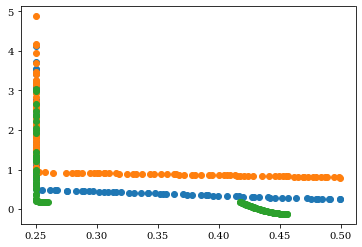

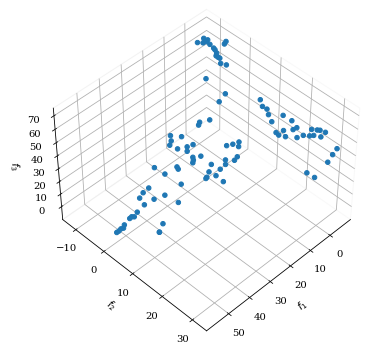

In [2]:
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)
pf2 = get_problem("dtlz1").pareto_front(ref_dirs) #the pareto front is the hyperplane such as sum(fi) = 0.5
igdplus = get_performance_indicator("igd+", pf2)
n_var = 4
n_obj = 3
dtlz1 = get_problem("dtlz1", n_var, n_obj)
bbox = pymoo2fun(dtlz1) #makes of a pymoo problem a function ndarray[ne,nx] -> ndarray[ne,ny]
xlim = np.zeros((n_var,2))
xlim[:,1]=1
momo = MOO(n_iter = 50, criterion = 'EHVI', xlimits = xlim, pop_size = 250)
momo.optimize(bbox)
front1 = momo.result.F
get_visualization("scatter", angle=(45,45)).add(front1).show()

## Optimization under constraints

In smoot, the constraints are modelized, because they are also considered as expensive to evaluate. As for the objectives, a gaussian kernel is used for the modelization. The constraints are supposed independants from each other and <u>must be constraints of the form</u> $ g(x) \leq 0$.
Then, a penality is applied during criterions maximization through the probability of feasibility :
$$ Criterion \; penalized \;(x) = Criterion(x) \times \prod_{1 \leq i \leq N_{constraints}} \Phi(\frac{0 - y_i(x)}{s(x)}) \; \; \; where \;\Phi\; is\; the\; normal\; cumulated\; density\; of \; probability$$

The genetic algorithm run at the end of the process on the surrogate model is also constrained by the means on the constraints' models.

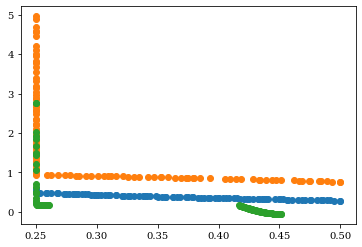

In [24]:
g = lambda x : x[:,0] - 0.5 #smoot takes g(x) <= 0 so here x0 <= 0.5
g2 = lambda x : 0.25 - x[:,0] #X0 >= 0.25
contrainte = [g, g2] #for only 1 constraint, const = [g]
moc = MOO(const = contrainte)
moc.optimize(ZDT())
resc = moc.result
plt.figure()
plt.scatter(resc.F[:,0],resc.F[:,1])
moc.optimize(ZDT(type = 2))
resc2 = moc.result
plt.scatter(resc2.F[:,0],resc2.F[:,1])
moc.optimize(ZDT(type = 3))
resc3 = moc.result
plt.scatter(resc3.F[:,0],resc3.F[:,1])
plt.show()